# Project 1

Max Schrader

AEM 591

## Install the Required Packages

**Uncomment based on the package manager that you use**

In [51]:
# !pip install pint
# !pip install plotly
# !pip install prettytable
# !pip install numpy
# !pip install scipy
# !pip install --upgrade nbformat
# !pip install sympy


# !conda commands (I think conda ships with numpy and scipy??)
# !conda install "jupyterlab>=3" "ipywidgets>=7.6" 
# !conda install -c conda-forge pint
# !conda install -c plotly plotly=5.3.1 
# !conda install -c conda-forge prettytable

Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'c:\program files\python36\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
import random
from dataclasses import dataclass
import math
from typing import Union

import pint
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import StateSpace, lsim
from prettytable import PrettyTable
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "ggplot2"

## Helper Functions

In [3]:
ureg = pint.UnitRegistry()

In [4]:
def pretty_print(array: np.array, headers: list) -> None:
    x = PrettyTable()
    x.field_names = headers
    if len(headers) > 1 and len(array.shape) < 2:
        x.add_row(list(map(lambda x: round(x, 3), array)))
    else:
        for row in array:
            #             if len(array.shape) > 1:
            x.add_row(list(map(lambda x: round(x, 3), row)) if isinstance(
                row, (list, np.ndarray)) else [round(row, 3)])

#             x.add_row(round(row, 3))
    print(x)


### Constants

In [5]:
@dataclass
class Elevator:

    I_m = 700 * ureg.kilogram * ureg.meter ** 2
    K = 100 * ureg.newton * ureg.meter / ureg.ampere
    K_v = 100 * ureg.volt * ureg.second
    L = 0.4 * ureg.H
    m = 500 * ureg.kg
    g = 1 * ureg.gravity
    W = 300 * ureg.kilogram * 1 * ureg.gravity
    r_0 = 3 * ureg.meter
    delta_c = 0.05 * ureg.meter
    R_0 = 5 * ureg.ohm
    delta_r = 5 * ureg.ohm
    t_r = 3 * ureg.second
    x = 0 * ureg.meter

    def r_t(self, x=None, *args, **kwargs) -> pint.Quantity:
        x = x or self.x
        return ((self.delta_c * x / math.pi + self.r_0 ** 2) ** (1/2)).to('meter')

    def R_t(self, t: float) -> pint.Quantity:
        return (self.R_0 + self.delta_r * (1 - math.exp((-1 * t * ureg.second) / self.t_r))).to('ohm')

    """ Doing the linearized points as @property is not computationaly 
    efficient but makes the code most readable for me """
    @property
    def x_dot_bar(self, ) -> ureg.meter:
        return 0 * ureg.meter

    @property
    def v_bar(self, ) -> ureg.volt:
        return (((self.m * self.g - self.W) * (self.R_0 + self.delta_r)) / self.K * self.r_bar).to('V')

    @property
    def i_bar(self, ) -> ureg.ampere:
        return (self.v_bar / (self.R_0 + self.delta_r)).to('A')

    @property
    def r_bar(self, ) -> ureg.meter:
        return self.r_t()  # (self.K / (self.m * self.g - self.W) * self.i_bar).to('meter')


## Problem 1

Setup two functions to compute the state and outputs in Python using the state-space system
representation above

In [6]:
class NonLinearElevator(Elevator):
    def __init__(self, x: float, doublet_d_t: float = None, doublet_c: float = None):

        self.doublet_c = doublet_c if isinstance(
            doublet_c, ureg.Quantity) else doublet_c * ureg.volt if doublet_c else None
        self.doublet_d_t = doublet_d_t.to('second').magnitude if isinstance(
            doublet_d_t, ureg.Quantity) else doublet_d_t if doublet_d_t else None
        self.x = x * ureg.meter

    def f(self, ) -> object:
        # return inner function because scipy odeint doesn't like OOP
        def _f(t: float, x_t: np.array) -> np.array:
            x_dot = np.zeros(4)

            # Time Variant Fns
            v_t = self.doublet(t)

            r_t = x_t[-1] * ureg.meter

            x_dot[0] = x_t[1]

            x_dot[1] = ((1 / (self.m * r_t - (self.I_m / r_t))) *
                        (
                            (self.W * r_t - self.m * self.g *
                             r_t + self.K * (x_t[2] * ureg.amp))
                - (self.I_m * self.delta_c * (x_t[1] * ureg.mps)**2) /
                (2 * math.pi * r_t ** 3)
            )
            ).to('m/s^2').magnitude

            x_dot[2] = \
                (v_t / self.L
                 - (self.R_t(t) / self.L * (x_t[2] * ureg.ampere))
                 - ((self.K_v * (x_t[1] * ureg.mps)) / (self.L * r_t))
                 ).to('A/s').magnitude

            x_dot[3] = (self.delta_c * (x_t[1] * ureg.mps) /
                        (2 * math.pi * r_t)).to('m/s').magnitude

            return x_dot

        return _f

    def doublet(self, t: float) -> ureg.volt:
        return {
            0: self.doublet_c + self.v_bar,
            1: -1 * self.doublet_c + self.v_bar,
            2: self.v_bar,
        }[min(t // (self.doublet_d_t / 2), 2)]


In [61]:
elevator = NonLinearElevator(x=0, doublet_c=1e-6, doublet_d_t=5)

x0 = np.array([15, 0, elevator.i_bar.magnitude, elevator.r_bar.magnitude])

In [73]:
A = Matrix(elevator.f()(t=1, x_t=x0))
# X = Matrix(np.array([15, 0, elevator.i_bar.magnitude, elevator.r_bar.magnitude]))
# X.jacobian(A)
# dir(A)

## Problem 2

Compute the linearized state-space system about three equilibrium/trim points at 𝑥 = 0,
15, and 30 m for a steady-state value of 𝑅 = 𝑅0 +𝛿𝑅, i.e. 𝑅(𝑡) as 𝑡 → ∞. Analyze the
controllability, observability, and stability in Python for the linearized system

In [7]:
class LinearElevator(NonLinearElevator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self.x = x * ureg.meter

    def R_t(self, *args, **kwargs) -> pint.Quantity:
        return self.R_0 + self.delta_r

    # splitting up the partials for readability
    def df1_dx(self, *args, **kwargs) -> np.array:
        return np.array(
            [
                0,
                1,
                0,
                0
            ])

    def df2_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                # (self.I_m * self.delta_c * x_t[1]) / (math.pi * self.m * r_t **4 + x_t[2] * math.pi * r_t ** 2) commented out because x_bar = 0
                0,
                ((self.K * self.r_bar) / (self.m * self.r_bar **
                 2 - self.I_m)).to('m/s^2/A').magnitude,
                #                 ((2 * self.I_m * math.pi * self.r_bar ** 4 * (self.g * self.m - self.W)) / (math.pi * self.r_bar ** 3 * (self.m * self.r_bar**2 - self.I_m) ** 2)).to('m/s^2/m').magnitude
                (((- 1 * self.g * self.m) + self.W) / (self.m*self.r_bar - self.I_m / self.r_bar) - \
                 (self.m + self.I_m / self.r_bar ** 2) * (-1 * self.g * self.m * self.r_bar + self.i_bar * self.K + self.r_bar * self.W) / \
                 ((self.m * self.r_bar - self.I_m / self.r_bar) ** 2)).to('m/s^2/m').magnitude
            ]
        )

    def df3_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                -1 * ((self.K) / (self.L * self.r_bar)).to('A/m').magnitude,
                -1 * (self.R_t() / self.L).to('1/s').magnitude,
                0  # because x_bar = 0
            ]
        )

    def df4_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                (self.delta_c / (2 * math.pi * self.r_bar)
                 ).to('dimensionless').magnitude,
                0,
                0
            ]
        )

    @property
    def A(self, ) -> np.array:
        return np.asarray(
            [
                self.df1_dx(),
                self.df2_dx(),
                self.df3_dx(),
                self.df4_dx()
            ]
        )

    @property
    def B(self, ) -> np.array:
        return np.asarray(
            [[
                0,
                0,
                (1 / self.L).to('A/s/V').magnitude,
                0
            ]]
        )

    @property
    def C(self, ) -> np.array:
        return np.asarray(
            [
                [1, 0, 0, 0],
                [0, 1, 0, 0]
            ]
        )

    @property
    def D(self, ) -> np.array:
        return np.asarray(
            [[0, 0, ]]
        )

    def fn(self, ):
        def _fn(t, x_t, ):

            self.x = x_t[0] * ureg.meter

            x_t = np.array([x_t[0] - 0, x_t[1] - 0, x_t[2] -
                           self.x.i_bar.magnitude, x_t[3] - self.x.r_bar.magnitude])

            return np.matmul(self.x.A, x_t) + np.matmul(self.x.B.T, np.asarray([self.x.doublet(t).magnitude - self.x.v_bar.magnitude]))

        return _fn


### State Space at $x = 0$

In [8]:
x = 0


#### $\textbf{A}$

In [9]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])


+-----+---------+-------+--------+
|  x  |  x_dot  |   i   |   r    |
+-----+---------+-------+--------+
| 0.0 |   1.0   |  0.0  |  0.0   |
| 0.0 |   0.0   | 0.079 | -1.548 |
| 0.0 | -83.333 | -25.0 |  0.0   |
| 0.0 |  0.003  |  0.0  |  0.0   |
+-----+---------+-------+--------+


#### $\textbf{B}$

In [10]:
pretty_print(elevator.B[0], ['v'])


+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [11]:
elevator.v_bar.to('V')


588.399 <Unit('volt')>

#### Stability

In [12]:
np.linalg.eigvals(elevator.A)


array([ 0.00000000e+00, -2.47340139e+01, -2.49335937e-01, -1.66501342e-02])

### Controllability

In [13]:
np.linalg.matrix_rank(elevator.A)

3

### State Space at $x = 15$

In [14]:
x = 15


#### $\textbf{A}$

In [15]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+--------+-------+--------+
|  x  | x_dot  |   i   |   r    |
+-----+--------+-------+--------+
| 0.0 |  1.0   |  0.0  |  0.0   |
| 0.0 |  0.0   | 0.078 | -1.521 |
| 0.0 | -82.25 | -25.0 |  0.0   |
| 0.0 | 0.003  |  0.0  |  0.0   |
+-----+--------+-------+--------+


#### $\textbf{B}$

In [16]:
pretty_print(elevator.B[0], ['v'])

+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [17]:
elevator.v_bar.to('V')

596.1518081980751 <Unit('volt')>

#### Stability

In [18]:
np.linalg.eigvals(elevator.A)

array([ 0.00000000e+00, -2.47421999e+01, -2.41111927e-01, -1.66881412e-02])

### Controllability

In [19]:
np.linalg.matrix_rank(elevator.A)

3

### State Space at $x = 30$

In [20]:
x = 30

#### $\textbf{A}$

In [21]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+---------+-------+--------+
|  x  |  x_dot  |   i   |   r    |
+-----+---------+-------+--------+
| 0.0 |   1.0   |  0.0  |  0.0   |
| 0.0 |   0.0   | 0.076 | -1.495 |
| 0.0 | -81.207 | -25.0 |  0.0   |
| 0.0 |  0.003  |  0.0  |  0.0   |
+-----+---------+-------+--------+


#### $\textbf{B}$

In [22]:
pretty_print(elevator.B[0], ['v'])

+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [23]:
elevator.v_bar.to('V')

603.8050791726326 <Unit('volt')>

#### Stability

In [24]:
np.linalg.eigvals(elevator.A)

array([ 0.00000000e+00, -2.47498971e+01, -2.33376426e-01, -1.67265107e-02])

### Controllability

In [25]:
np.linalg.matrix_rank(elevator.A)

3

## Problem 3

Simulate the nonlinear system with a doublet input for 𝑣 about  ̄𝑣 for initial conditions close and
far from the three equilibrium points from part 2, but including 𝑡. Use a doublet magnitude
which keeps the elevator velocity reasonable.

In [26]:
x = [0, 15, 30]

In [36]:
def nonlinear_analysis(x: int, doublet_magnitude, i_0: pint.Quantity = None, ):

    doublet_dt = 5
    t = np.linspace(0, doublet_dt / 2 * 3, 1000)

    elevator = NonLinearElevator(
        x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

    # compose the initial conditions
    x0 = np.array([x, 0, i_0 or elevator.i_bar.magnitude, elevator.r_bar.magnitude])

    pretty_print(x0, headers=['x_0', 'x_dot_0', 'i_0', 'r_0'])

    s = solve_ivp(elevator.f(), y0=x0, t_span=(t[0], t[-1]), max_step=0.01)

    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

    fig.add_trace(go.Scatter(x=s.t, y=s.y[0]), row=1, col=1)
    fig.add_trace(go.Scatter(x=s.t, y=s.y[1]), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=[elevator.doublet(
        _t).magnitude for _t in t]), row=3, col=1)

    fig.update_layout(
        showlegend=False,
        title=f"Initial Position={round(elevator.x, 1)}  |  Voltage={round(elevator.v_bar, 2)} ± {round(elevator.doublet_c, 2)}",
        height=700,
        width=1000,
        xaxis3=dict(title="time [s]"),
        yaxis=dict(title='position [m]'),
        yaxis2=dict(title='velocity [m/s]'),
        yaxis3=dict(title='voltage [volts]')
    )

#     incase jupyterlab plotly extension isn't installed
#     Image(fig.to_image(format="png")

    fig.show()


### $x = 0$

+-----+---------+-------+-----+
| x_0 | x_dot_0 |  i_0  | r_0 |
+-----+---------+-------+-----+
| 0.0 |   0.0   | 58.84 | 3.0 |
+-----+---------+-------+-----+


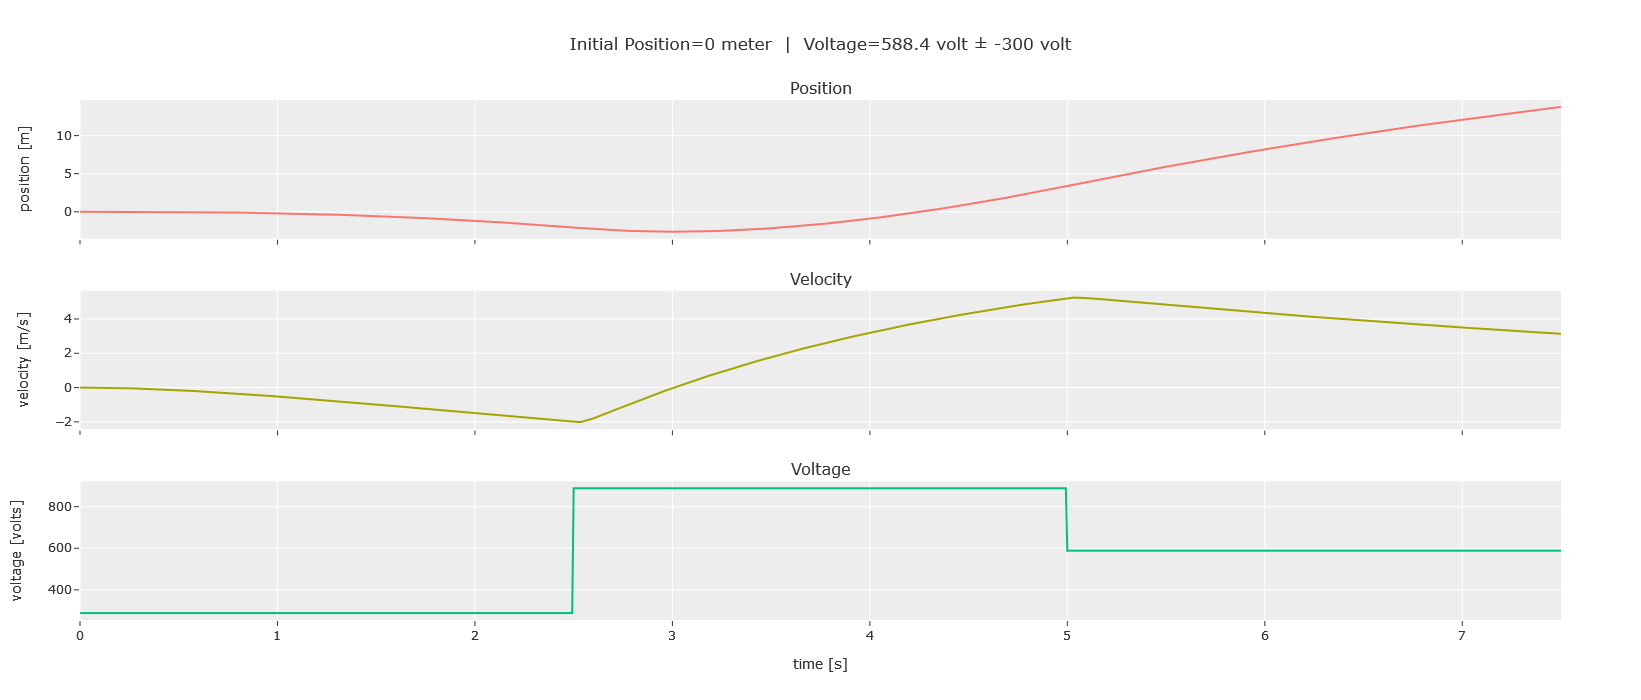

In [46]:
nonlinear_analysis(0, doublet_magnitude=-300, )

### $x = 15$

In [47]:
# nonlinear_analysis(15, doublet_magnitude=10)

### $x = 30$

+------+---------+--------+-------+
| x_0  | x_dot_0 |  i_0   |  r_0  |
+------+---------+--------+-------+
| 30.0 |   0.0   | 60.381 | 3.079 |
+------+---------+--------+-------+


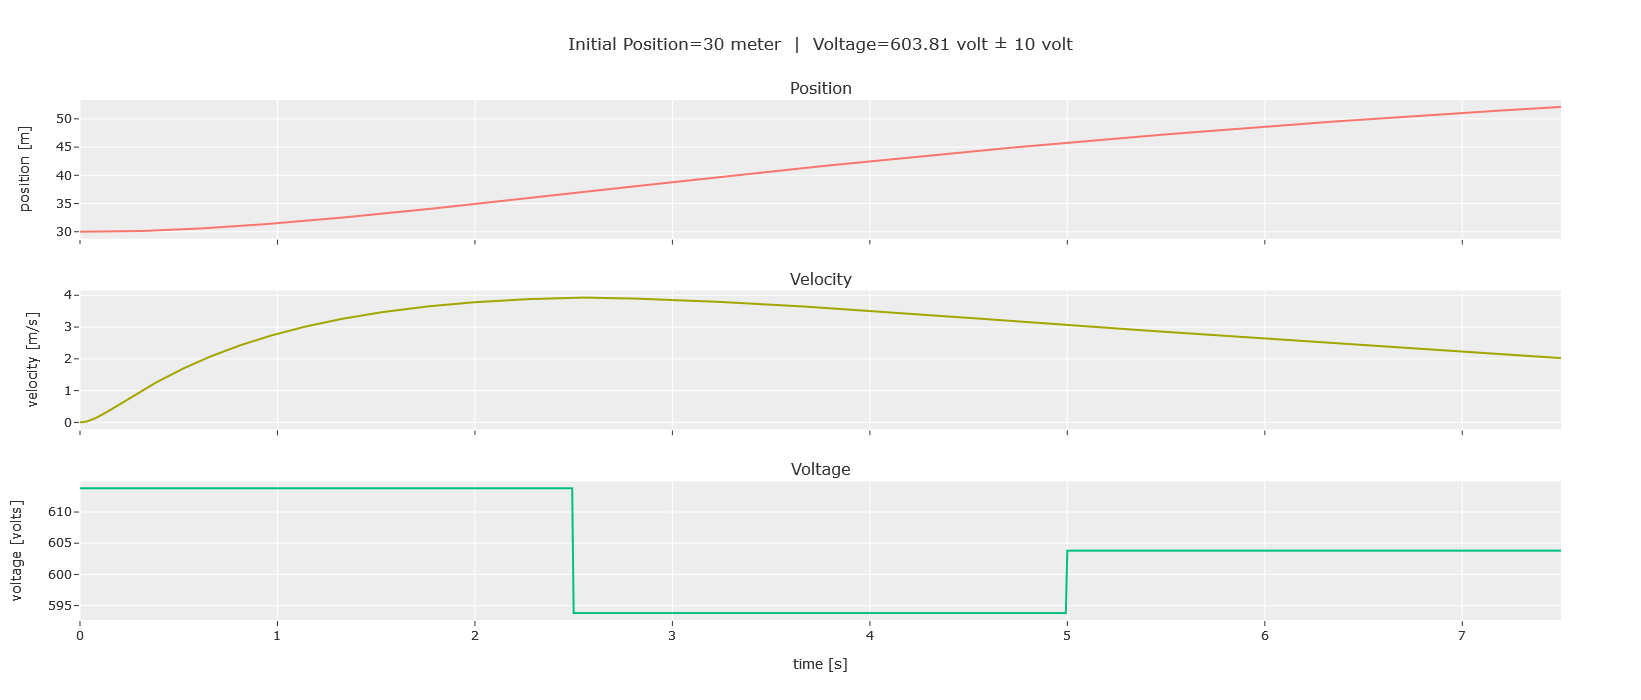

In [30]:
nonlinear_analysis(30, doublet_magnitude=10)

### Far Away from Initial Conditions

In [31]:
x = random.randint(30, 100)
v = random.randint(80, 1000)

+------+---------+--------+-------+
| x_0  | x_dot_0 |  i_0   |  r_0  |
+------+---------+--------+-------+
| 71.0 |   0.0   | 62.425 | 3.183 |
+------+---------+--------+-------+


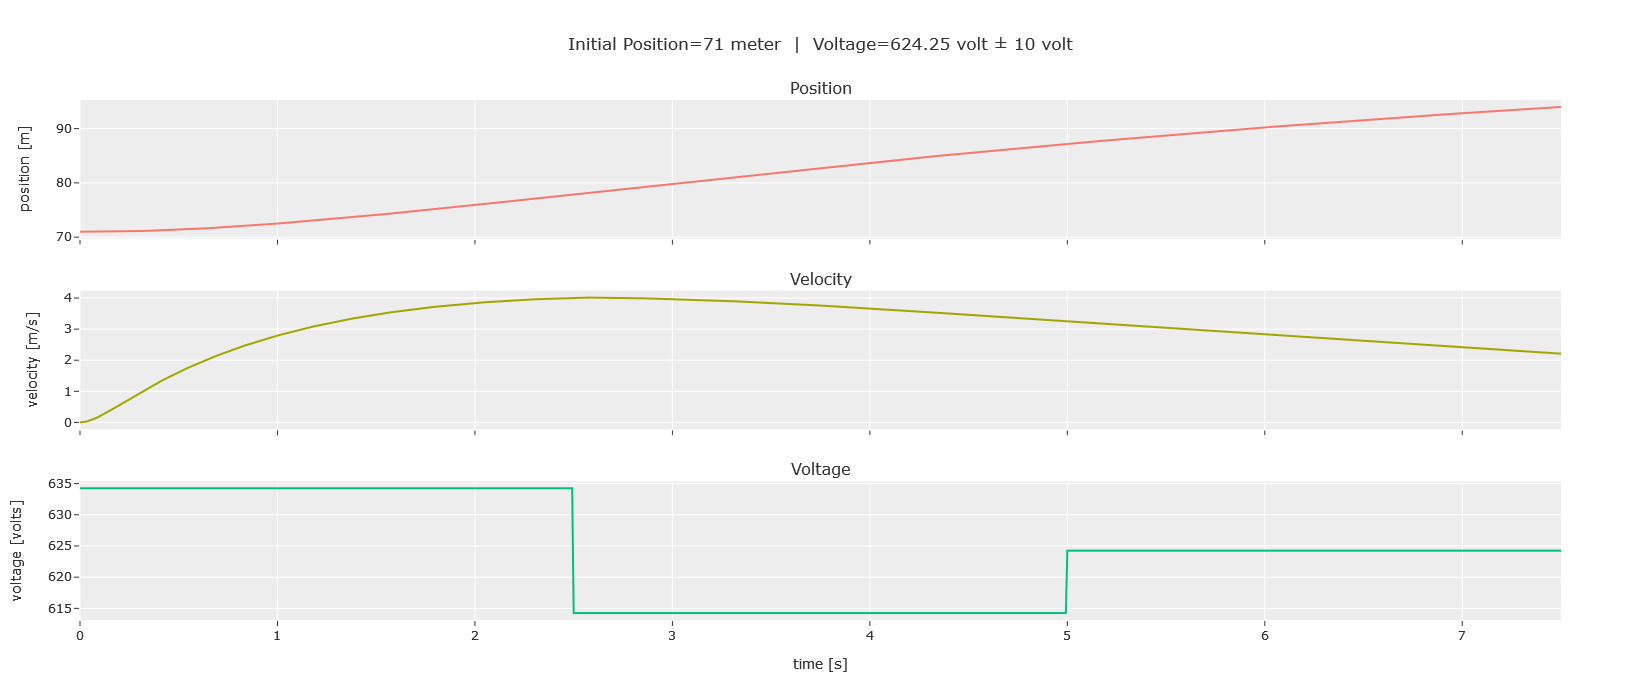

In [32]:
nonlinear_analysis(x, doublet_magnitude=10)

## Problem 4

Simulate the linearized system with a doublet input for Δ𝑣 for initial conditions close and
far from the three equilibrium points from part 2. Use a doublet magnitude which keep the
elevator velocity reasonable

In [48]:
def linear_analysis(x, doublet_magnitude, method='ivp', i_0: float = 0, ):

    doublet_dt = 5

    # create the time vector
    t = np.linspace(0, doublet_dt / 2 * 3, 1000)

    # create the elevator object
    elevator = LinearElevator(x=x, 
                              doublet_c=doublet_magnitude, 
                              doublet_d_t=doublet_dt)

    x0 = np.array([elevator.x.magnitude, 0, i_0 or elevator.i_bar.magnitude, elevator.r_bar.magnitude])

    pretty_print(x0, headers=['x_0', 'x_dot_0', 'i_0', 'r_0'])

    # solving the scipy StateSpace + lsim way
    if method in 'lsim':
        U = np.asarray(list(elevator.doublet(_t).magnitude for _t in t))
        elevator_ss = StateSpace(
            elevator.A, elevator.B.T, elevator.C, elevator.D.T)
        _, y, s = lsim(elevator_ss, U, t, X0=x0)
        pos = [_y[0] for _y in y]
        v = [_y[1] for _y in y]
        t_ode = t

    else:
        # solving with solve_ivp
        s = solve_ivp(elevator.f(), y0=x0, max_step=0.01, t_span=(t[0], t[-1]))
        pos = s.y[0]
        v = s.y[1]
        t_ode = s.t

    # plotting the results
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

    fig.add_trace(go.Scatter(x=t_ode, y=pos), row=1, col=1)
    fig.add_trace(go.Scatter(x=t_ode, y=v), row=2, col=1)
    fig.add_trace(go.Scatter(x=t_ode, y=[elevator.doublet(
        _t).magnitude for _t in t]), row=3, col=1)

    fig.update_layout(
        showlegend=False,
        title=f"Initial Position={round(elevator.x, 1)}  |  Voltage={round(elevator.v_bar, 2)} ± {round(elevator.doublet_c, 2)}",
        height=700,
        width=1000,
        xaxis3=dict(title="time [s]"),
        yaxis=dict(title='position [m]'),
        yaxis2=dict(title='velocity [m/s]'),
        yaxis3=dict(title='voltage [volts]')
    )

    fig.show()


### Position $x = 0$

+-----+---------+-------+-----+
| x_0 | x_dot_0 |  i_0  | r_0 |
+-----+---------+-------+-----+
| 0.0 |   0.0   | 58.84 | 3.0 |
+-----+---------+-------+-----+


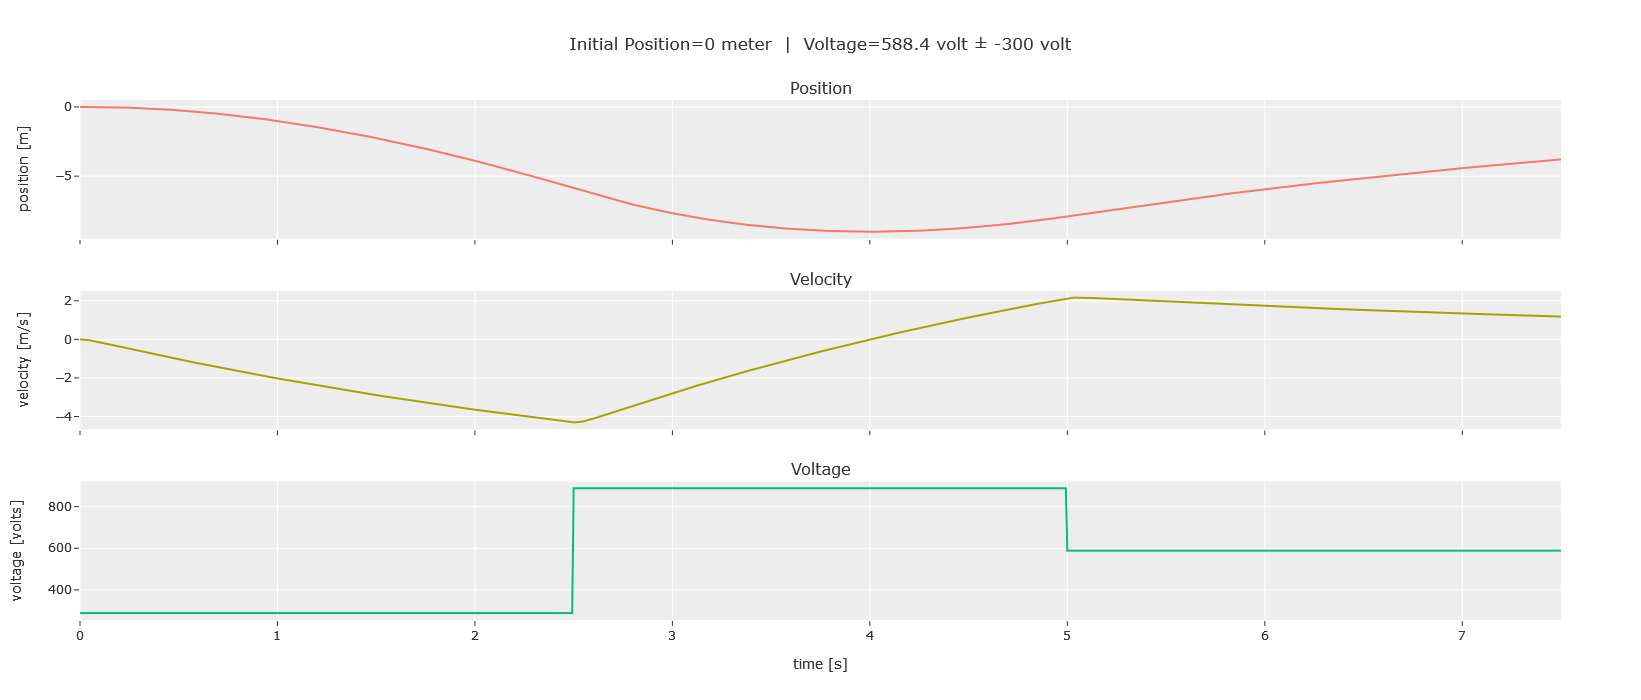

In [50]:
x = 0
linear_analysis(x, doublet_magnitude=-300, method='lsim', )

### Position $x = 15$

In [ ]:
x = 15
linear_analysis(x, doublet_magnitude=10)

### Position $x = 30$

In [ ]:
x = 30
linear_analysis(x, doublet_magnitude=10)

## Problem 5

Write a few paragraphs summarizing the results of these simulations and any analysis. Make sure to compare the linear simulations to the nonlinear.